Want to show that the compression of the digit (log evidence) is already enough for classification and to find out which digits may be similar.



- [ ] Calculate log evidence of whole digit 
    - [ ] Absolute value per digit => how compressible is that digit
    - [ ] Q: even without testing looking for the best model will already classify the digit, simply because some digits are more compressible than others
    - [ ] Log evidence distribution
    - [ ] Y = log evidence for actual model on whole dataset fitted
        - [ ] Each line is a digit 
    - [ ] X = 20x 20 digits for each fit MCM and compute distribution of log evidence
    - [ ] Dont divide by 121 so its bitwise 
    - [ ] Without testing, simple choice of model 
    - [ ] Measure of compressibility is enough to classify


In [1]:
# 1. need for each digit the image/bitwise evidence of the full MCM (6313 samples) -> 10 numbers
# 2. For N = 20 (make this variable maybe wanna try our 100 too) compute the log evidence for multiple runs for all digits -> runs*10 numbers

In [2]:
# 1. 


In [40]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
from src.loaders import load_data, load_labels
from src.classify import MCM_Classifier
import os
import src.plot as myplot
import scipy.ndimage as ndi

In [41]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/plot.py'>

In [42]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/paper_utils.py'>

In [43]:
# Ps = classifier.get_P() # category, icc in MCM, 2**rank_icc probability distribution
# MCMs = classifier.get_MCMs()
# Counts = classifier.get_Counts()
# N = Counts[0][0].sum().astype(int) 


In [28]:
digit = 0

sample_sizes_full = [6315]
samplesiz_i = 0
run_i = 0

path_format = "../data/OUTPUT/mcm/sample_sizes_fromfull"

counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes_full, "",path_format)
Counts_full, MCMs_full = counts_samplesizes[samplesiz_i][run_i], mcms_samplesizes[samplesiz_i][run_i] # load first sample size and first run


In [47]:
evds = []
comms = []
for mcm_idx in np.arange(10):
    comms.append(myplot.generate_icc_comms_map(MCMs_full[mcm_idx]))
    evd = utils.evidence_iccs(Counts_full,MCMs_full,mcm_idx)
    evd = utils.pixelwise_evidence(evd,sample_sizes_full[0],MCMs_full[mcm_idx], image_wise=True) 
    evd = np.sum(evd) # image wise overall evidence of the model
    evds.append(evd)

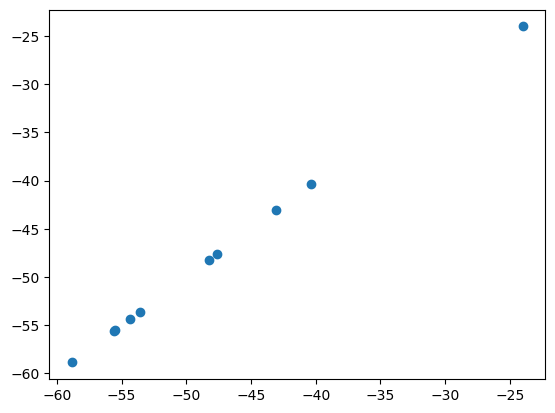

In [50]:

# plt.scatter(evds,evds)
